In [74]:
import nltk
import pandas as pd
import numpy as np
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import re
import csv
import textblob
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer
import matplotlib.pyplot as plt
nltk.download('vader_lexicon')
nltk.download('wordnet')
warnings.filterwarnings('ignore') 
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/apple/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [75]:
# read file
df_07= pd.read_csv('data_2012-06-26_eur_usd.csv')
df_08= pd.read_csv('data_2012-07-26_eur_usd.csv')
df78=pd.concat([df_07,df_08]) # merge 

### Preprocess

In [76]:
def preprocess(df):
    stop = stopwords.words('english')
    lmtzr = WordNetLemmatizer()
    stemmer = SnowballStemmer("english")
    reg_map = {
          re.compile("rt [@0-9a-z_]{0,10}:"),
          re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"),
          re.compile("#[0-9a-z]+"),
          re.compile("@[0-9a-z]+"),
}

    def lower_and_remove_with_reg(text: str) -> str:
        text = text.lower()
        for v in reg_map:
            text = v.sub("", text)
        return text
    df['cleaned']=df['tweet'].apply(lower_and_remove_with_reg).replace('[^a-zA-Z0-9 ]', '', regex=True).apply(nltk.word_tokenize).apply(lambda x: [item for item in x if item not in stop]).apply(lambda lst:[lmtzr.lemmatize(word) for word in lst]).apply(lambda x: [stemmer.stem(y) for y in x]).apply(lambda x: ' '.join([item for item in x if len(item)>2]))
# df['txt_lowercase']=df['text'].str.lower()
    return df

In [77]:
df_78=preprocess(df78)[['created_at','cleaned']]
df_78

,created_at,cleaned
0,2012-07-25 20:46:33+00:00,raft select tonight usdcad eurgbp audusd remem...
1,2012-07-25 18:20:18+00:00,200 mma keep floor eurusd itali downgrad eurus...
2,2012-07-25 17:26:51+00:00,fresh short issu eurusd audusd
3,2012-07-25 14:41:11+00:00,eurjpi eurusd play correct 9470 1209
4,2012-07-25 14:11:22+00:00,revis eurusd goal reach 1221 instead 1225 due ...
...,...,...
492,2012-07-26 13:49:55+00:00,zone eurusd 2300 2320 import resist area expec...
493,2012-07-26 13:40:06+00:00,stop euraud short usdchf long trade loss
494,2012-07-26 13:39:14+00:00,eurusd modelanoth great entri work
495,2012-07-26 11:17:57+00:00,124 eurusd major resist break revers hand


## TextBlob, Vader, NLTK

In [78]:
#!pip install textblob
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [79]:
vaderanalyzer= SentimentIntensityAnalyzer()
nltk_analyzer = SentimentIntensityAnalyzer()

In [80]:
# get sentiment scores
df_78['textblob_polarity']=df_78['cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_78['textblob_subjectivity']=df_78['cleaned'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df_78['nltk'] = df_78['cleaned'].apply(lambda x: nltk_analyzer.polarity_scores(x)['compound'])
df_78['vader']=df_78['cleaned'].apply(lambda x: vaderanalyzer.polarity_scores(x))
df_4weeks=df_78[['created_at','cleaned','textblob_polarity','textblob_subjectivity','nltk','vader']]
df_4weeks.to_csv('0708.csv')

In [81]:
# resampling by week
df_4weeks['week']=pd.to_datetime(df_4weeks['created_at']).dt.week
df_4weeks=df_4weeks[['created_at','week','cleaned','textblob_polarity','textblob_subjectivity','nltk','vader']]

In [82]:
df_4weeks.sort_values(by='week',ascending=True)

,created_at,week,cleaned,textblob_polarity,textblob_subjectivity,nltk,vader
549,2012-06-28 12:52:51+00:00,26,sampp futur correl cross similar wors audjpi a...,0.000000,0.200000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
542,2012-06-29 04:27:36+00:00,26,nice move happi catch alert set wer eur usd we...,0.600000,1.000000,0.7269,"{'neg': 0.0, 'neu': 0.585, 'pos': 0.415, 'comp..."
543,2012-06-29 03:49:01+00:00,26,usd index fail 8260 eurusd revers strong 12440...,-0.033333,0.516667,-0.0516,"{'neg': 0.254, 'neu': 0.507, 'pos': 0.239, 'co..."
544,2012-06-29 00:08:23+00:00,26,buy usd 150 160 eur nok abl get diet coke least,-0.300000,0.400000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
545,2012-06-28 22:05:19+00:00,26,move stop 12460 eurusd target hit mayb see tar...,0.000000,0.000000,-0.2960,"{'neg': 0.18, 'neu': 0.82, 'pos': 0.0, 'compou..."
...,...,...,...,...,...,...,...
82,2012-08-21 12:49:51+00:00,34,eurusd clear away offer stop 12460 high,0.130000,0.461667,0.1027,"{'neg': 0.224, 'neu': 0.51, 'pos': 0.265, 'com..."
83,2012-08-21 12:49:51+00:00,34,eurusd clear away offer stop 12460 high,0.130000,0.461667,0.1027,"{'neg': 0.224, 'neu': 0.51, 'pos': 0.265, 'com..."
84,2012-08-21 12:07:00+00:00,34,eurusd long target hit eurgbp audjpi long mone...,-0.050000,0.400000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
71,2012-08-21 16:09:55+00:00,34,head shoulder minut eurusd drop heavi short,0.000000,0.300000,-0.2732,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp..."


In [83]:
df_4weeks.to_csv('4weeks.csv')

In [84]:
# compute positive and negative ratio
def posneg_ratio(df):
    neg=df[df['textblob_polarity']<0].count()[0]
    pos=df[df['textblob_polarity']>0].count()[0]
    num=df.shape[0]
    negrt=neg/num
    posrt=pos/num
    return (negrt, posrt)

## Plot

###  Textblob

In [85]:
positive=df_4weeks.groupby('week').apply(lambda x: posneg_ratio(x)[1])
negative=df_4weeks.groupby('week').apply(lambda x: posneg_ratio(x)[0])

Text(0.5, 1.0, 'Positive ratio before and after the talk')

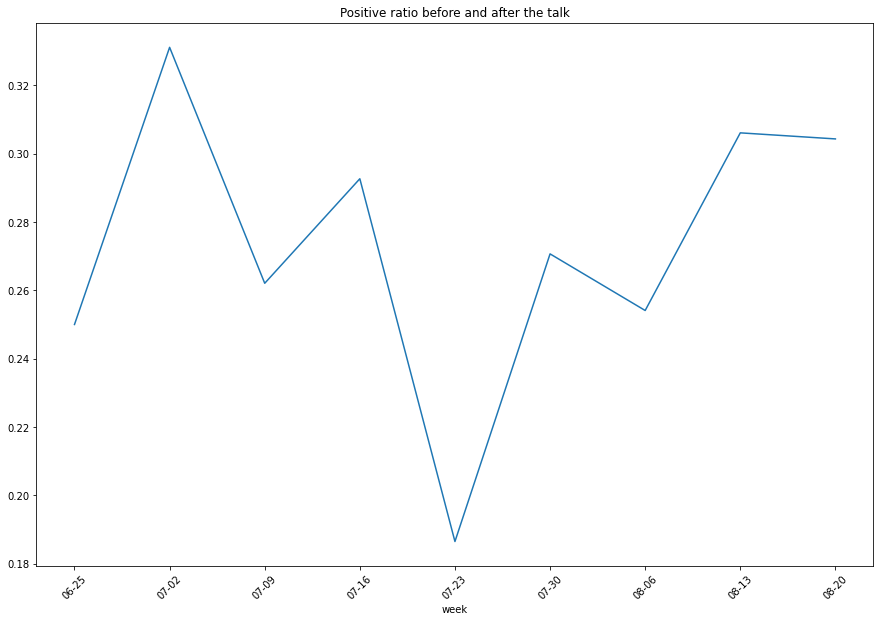

In [86]:
# in separate plots
ax = positive.plot(kind='line', rot=45,figsize=(15,10))
ax.set_xticklabels(['06-18','06-25','07-02','07-09','07-16','07-23','07-30','08-06','08-13','08-20'])
ax.set_title('Positive ratio before and after the talk')

Text(0.5, 1.0, 'Negative ratio before and after the talk')

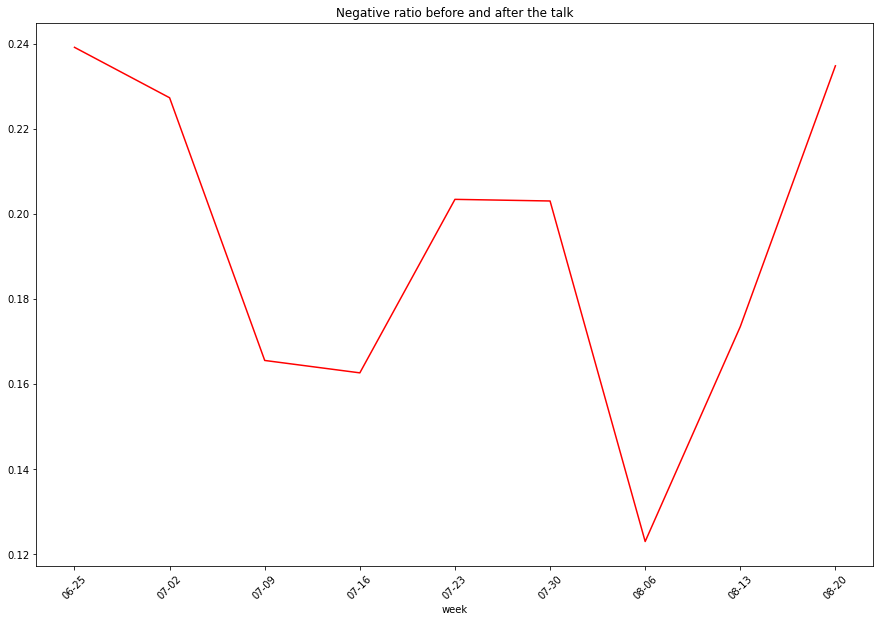

In [87]:
ax1 = negative.plot(kind='line', rot=45,figsize=(15,10),color='red')
ax1.set_xticklabels(['06-18','06-25','07-02','07-09','07-16','07-23','07-30','08-06','08-13','08-20'])
ax1.set_title('Negative ratio before and after the talk')

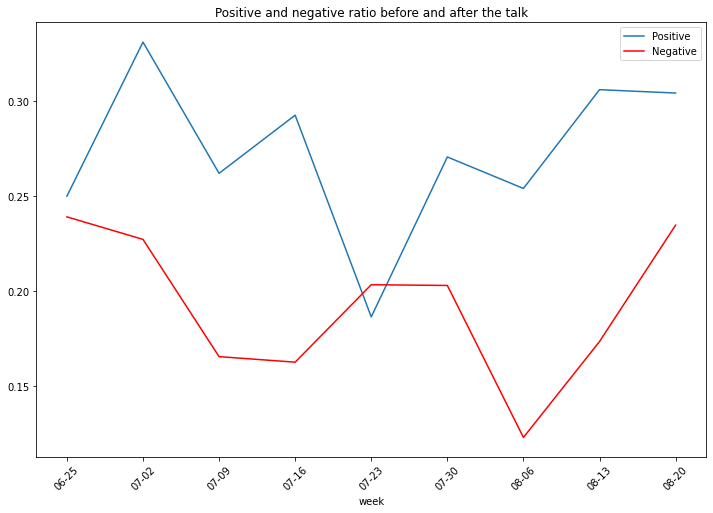

In [88]:
# in the same plot
ax2 = positive.plot(kind='line', rot=45,figsize=(12,8),label = 'Positive')
ax3 = negative.plot(kind='line', rot=45,figsize=(12,8),color='red',label = 'Negative')
ax2.set_xticklabels(['06-18','06-25','07-02','07-09','07-16','07-23','07-30','08-06','08-13','08-20'])
ax2.set_title('Positive and negative ratio before and after the talk')
ax2.legend()

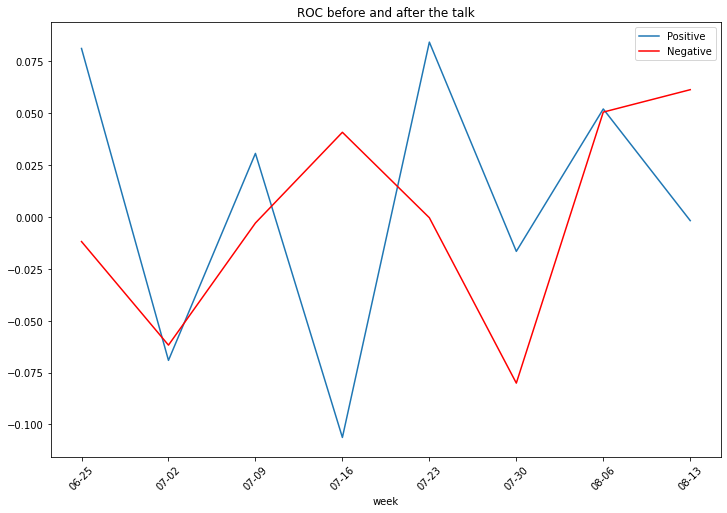

In [212]:
# ROC derivative
import matplotlib.pyplot as plt
from sympy.plotting import plot
from sympy import diff

ax4=diff(positive).plot(kind='line', rot=45,figsize=(12,8),label = 'Positive')
ax5=diff(negative).plot(kind='line', rot=45,figsize=(12,8),label = 'Negative',color='red')
ax4.set_xticklabels(['06-18','06-25','07-02','07-09','07-16','07-23','07-30','08-06','08-13','08-20'])
ax4.set_title('ROC before and after the talk')
ax4.legend()

## by week from 0726 

In [104]:
# sum by weeks
df_4weeks['time']=pd.to_datetime(df_4weeks['created_at']).dt.date


In [112]:
df_4weeks.sort_values(by='time',ascending=True,inplace=True)
df_4weeks.to_csv('df_4weeks_new.csv')
df_4weeks.reset_index(inplace=True)
df_4weeks

,index,created_at,week,cleaned,textblob_polarity,textblob_subjectivity,nltk,vader,time
0,589,2012-06-26 16:37:04+00:00,26,eurusd react test 12500 merkel comment,0.000000,0.000000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-06-26
1,601,2012-06-26 07:27:45+00:00,26,remeb today spanish dutch auction disturb poss...,0.000000,0.000000,0.0000,"{'neg': 0.201, 'neu': 0.597, 'pos': 0.201, 'co...",2012-06-26
2,600,2012-06-26 08:01:13+00:00,26,blame everi move bond eurusd eurozon concern l...,0.000000,0.000000,-0.5106,"{'neg': 0.301, 'neu': 0.699, 'pos': 0.0, 'comp...",2012-06-26
3,595,2012-06-26 11:00:36+00:00,26,much money would difficult get eurusd posit,-0.150000,0.600000,-0.3612,"{'neg': 0.294, 'neu': 0.706, 'pos': 0.0, 'comp...",2012-06-26
4,599,2012-06-26 08:11:17+00:00,26,long gold cabl audusd wit short eurusd that mo...,-0.025000,0.350000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-06-26
...,...,...,...,...,...,...,...,...,...
1095,6,2012-08-24 13:40:40+00:00,34,yup agre bullish usd commod currenc eur time f...,0.000000,0.000000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-08-24
1096,3,2012-08-24 15:56:02+00:00,34,like follow trade shes evid expert often learn...,0.000000,0.000000,0.3612,"{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp...",2012-08-24
1097,2,2012-08-24 16:00:07+00:00,34,global equiti market eurusd recov report ecb c...,0.068182,0.227273,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-08-24
1098,14,2012-08-24 05:55:51+00:00,34,short eurusd 2552 sl2650 first pt2513 second 2468,0.083333,0.211111,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-08-24


In [155]:
df_final=df_4weeks.loc[41:1084,:]
df_final['date']=pd.to_datetime(df_final['time']).dt.strftime('%Y-%m-%d')
df_final['unix']=pd.to_datetime(df_final['created_at']).map(pd.Timestamp.timestamp)
df_final.to_csv('df_final.csv')
df_final

,index,created_at,week,cleaned,textblob_polarity,textblob_subjectivity,nltk,vader,time,date,unix
41,559,2012-06-28 05:42:22+00:00,26,bring eurusd audusd,0.000000,0.000000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-06-28,2012-06-28,1.340862e+09
42,558,2012-06-28 06:53:40+00:00,26,alert eurusd determin german unemploy chang co...,0.000000,0.000000,0.2960,"{'neg': 0.0, 'neu': 0.845, 'pos': 0.155, 'comp...",2012-06-28,2012-06-28,1.340866e+09
43,545,2012-06-28 22:05:19+00:00,26,move stop 12460 eurusd target hit mayb see tar...,0.000000,0.000000,-0.2960,"{'neg': 0.18, 'neu': 0.82, 'pos': 0.0, 'compou...",2012-06-28,2012-06-28,1.340921e+09
44,557,2012-06-28 07:03:47+00:00,26,rememb italian auction soon gtgt choppi road e...,0.000000,0.000000,0.4019,"{'neg': 0.0, 'neu': 0.856, 'pos': 0.144, 'comp...",2012-06-28,2012-06-28,1.340867e+09
45,553,2012-06-28 10:34:46+00:00,26,think good idea buy gbpusd eurusd short stop loss,0.350000,0.450000,-0.1531,"{'neg': 0.336, 'neu': 0.448, 'pos': 0.216, 'co...",2012-06-28,2012-06-28,1.340880e+09
...,...,...,...,...,...,...,...,...,...,...,...
1080,20,2012-08-23 13:22:56+00:00,34,good morn sell usd 10093 gbp 16169 eur 12865 c...,0.750000,0.675000,0.7906,"{'neg': 0.0, 'neu': 0.632, 'pos': 0.368, 'comp...",2012-08-23,2012-08-23,1.345728e+09
1081,21,2012-08-23 11:29:37+00:00,34,aud eur slight usd follow bullard comment,-0.166667,0.166667,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-08-23,2012-08-23,1.345721e+09
1082,18,2012-08-23 15:41:52+00:00,34,eurusd short 2580 stopp 12650 target 12405 lower,0.000000,0.300000,-0.2960,"{'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'comp...",2012-08-23,2012-08-23,1.345737e+09
1083,19,2012-08-23 15:28:42+00:00,34,gon look eurusd chart look buck get readi shor...,0.000000,0.150000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-08-23,2012-08-23,1.345736e+09


In [162]:
weekbins=[1340862142,1341489271,1342098523,1342684407,1343310595,1343897164,1344510479,1345101364,1345740657]
np.array(df_final['unix'], dtype=float)

array([1.34086214e+09, 1.34086642e+09, 1.34092112e+09, ...,
       1.34573651e+09, 1.34573572e+09, 1.34574066e+09])

In [171]:
df_final

,index,created_at,week,cleaned,textblob_polarity,textblob_subjectivity,nltk,vader,time,date,unix,range
41,559,2012-06-28 05:42:22+00:00,26,bring eurusd audusd,0.000000,0.000000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-06-28,2012-06-28,1.340862e+09,2012-06-28
42,558,2012-06-28 06:53:40+00:00,26,alert eurusd determin german unemploy chang co...,0.000000,0.000000,0.2960,"{'neg': 0.0, 'neu': 0.845, 'pos': 0.155, 'comp...",2012-06-28,2012-06-28,1.340866e+09,2012-06-28
43,545,2012-06-28 22:05:19+00:00,26,move stop 12460 eurusd target hit mayb see tar...,0.000000,0.000000,-0.2960,"{'neg': 0.18, 'neu': 0.82, 'pos': 0.0, 'compou...",2012-06-28,2012-06-28,1.340921e+09,2012-06-28
44,557,2012-06-28 07:03:47+00:00,26,rememb italian auction soon gtgt choppi road e...,0.000000,0.000000,0.4019,"{'neg': 0.0, 'neu': 0.856, 'pos': 0.144, 'comp...",2012-06-28,2012-06-28,1.340867e+09,2012-06-28
45,553,2012-06-28 10:34:46+00:00,26,think good idea buy gbpusd eurusd short stop loss,0.350000,0.450000,-0.1531,"{'neg': 0.336, 'neu': 0.448, 'pos': 0.216, 'co...",2012-06-28,2012-06-28,1.340880e+09,2012-06-28
...,...,...,...,...,...,...,...,...,...,...,...,...
1080,20,2012-08-23 13:22:56+00:00,34,good morn sell usd 10093 gbp 16169 eur 12865 c...,0.750000,0.675000,0.7906,"{'neg': 0.0, 'neu': 0.632, 'pos': 0.368, 'comp...",2012-08-23,2012-08-23,1.345728e+09,2012-08-16
1081,21,2012-08-23 11:29:37+00:00,34,aud eur slight usd follow bullard comment,-0.166667,0.166667,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-08-23,2012-08-23,1.345721e+09,2012-08-16
1082,18,2012-08-23 15:41:52+00:00,34,eurusd short 2580 stopp 12650 target 12405 lower,0.000000,0.300000,-0.2960,"{'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'comp...",2012-08-23,2012-08-23,1.345737e+09,2012-08-16
1083,19,2012-08-23 15:28:42+00:00,34,gon look eurusd chart look buck get readi shor...,0.000000,0.150000,0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2012-08-23,2012-08-23,1.345736e+09,2012-08-16


In [174]:
df_final['range']=pd.cut(x=df_final['unix'],bins=weekbins,right=False,labels=['2012-06-28','2012-07-05','2012-07-12','2012-07-19','2012-07-26','2012-08-02','2012-08-09','2012-08-16'])



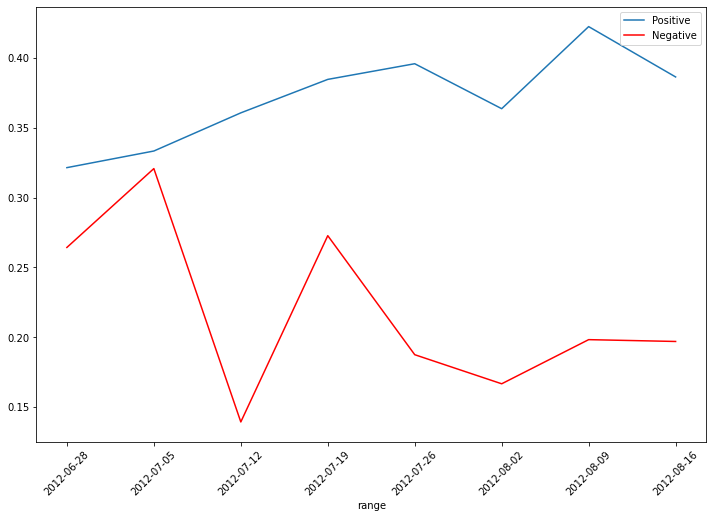

In [189]:
positive=df_final.groupby(['range']).apply(lambda x : posneg_ratio(x)[1])
negative=df_final.groupby(['range']).apply(lambda x : posneg_ratio(x)[0])
n=positive.plot(kind='line', rot=45,figsize=(12,8),label = 'Positive')
m=negative.plot(kind='line', rot=45,figsize=(12,8),color='red',label = 'Negative')
m.legend()

### NLTK

In [190]:
def posneg_ratio(df):
    neg=df[df['nltk']<0].count()[0]
    pos=df[df['nltk']>0].count()[0]
    num=df.shape[0]
    negrt=neg/num
    posrt=pos/num
    return (negrt, posrt)

In [191]:
positive=df_4weeks.groupby('week').apply(lambda x: posneg_ratio(x)[1])
negative=df_4weeks.groupby('week').apply(lambda x: posneg_ratio(x)[0])

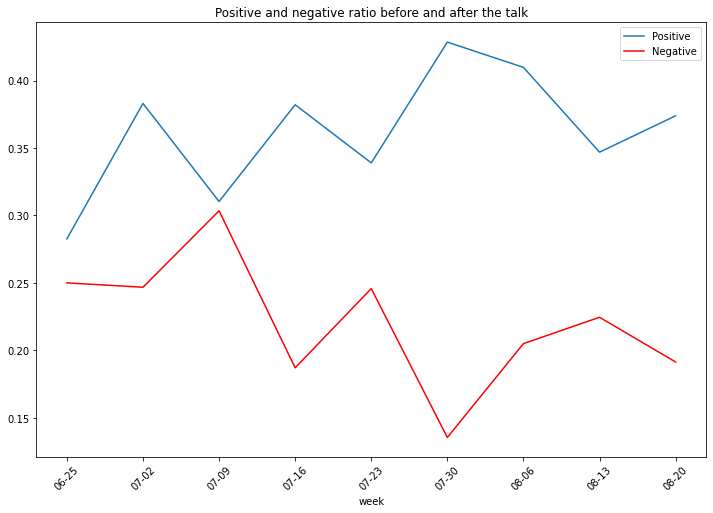

In [192]:
ax2 = positive.plot(kind='line', rot=45,figsize=(12,8),label = 'Positive')
ax3 = negative.plot(kind='line', rot=45,figsize=(12,8),color='red',label = 'Negative')
ax2.set_xticklabels(['06-18','06-25','07-02','07-09','07-16','07-23','07-30','08-06','08-13','08-20'])
ax2.set_title('Positive and negative ratio before and after the talk')
ax2.legend()

Text(0.5, 1.0, 'Difference between positive and negative ratio')

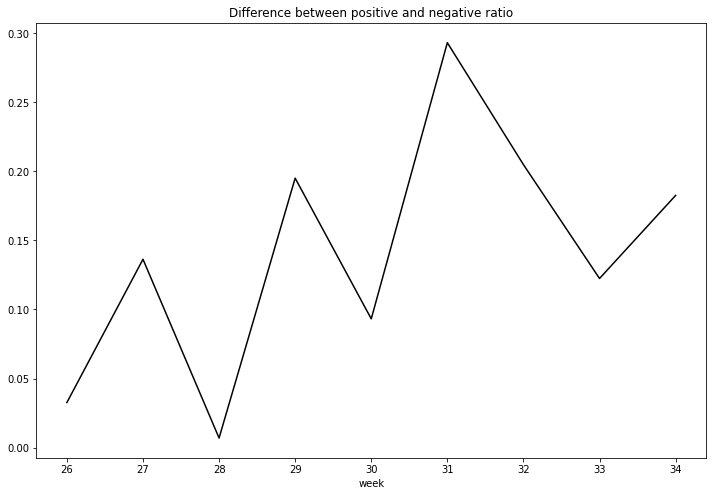

In [204]:
difference=positive-negative
m=difference.plot(kind='line',figsize=(12,8),color='black')
m.set_title('Difference between positive and negative ratio')

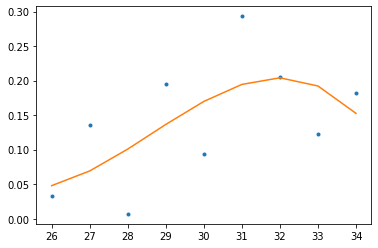

In [232]:
z=polyfit(difference.index,difference,3)
p1 = np.poly1d(z) 
y_pre = p1(difference.index)

plt.plot(difference.index,difference,'.')
plt.plot(difference.index,y_pre)
plt.show()


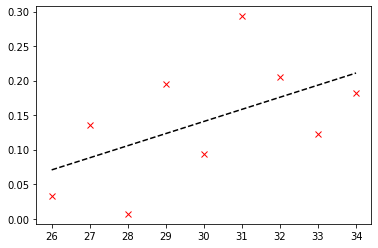

In [228]:

##from numpy import polyfit, poly1d
##polyfit(difference.index,difference,3)
##from scipy import stats
##from scipy.stats import linregress

##slope, intercept, r_value, p_value, stderr = linregress(difference.index, difference)
##slope, intercept
##p = plt.plot(difference.index,  difference, 'rx')
##p = plt.plot(difference.index, slope * difference.index + intercept, 'k--')

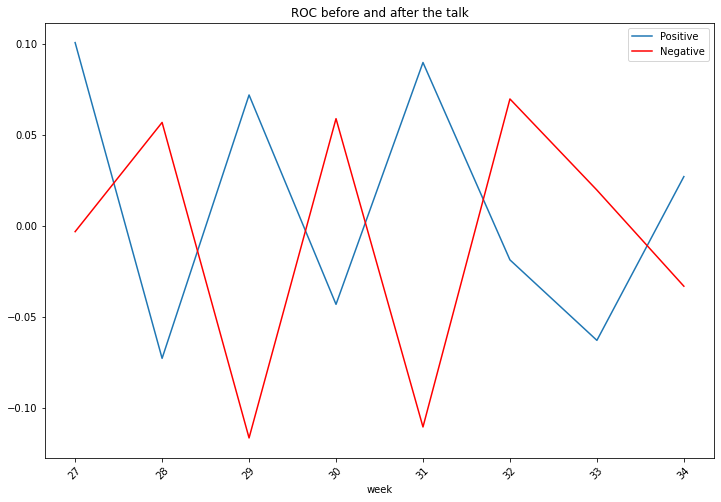

In [33]:
import matplotlib.pyplot as plt
from sympy.plotting import plot
from sympy import diff
ax4=diff(positive).plot(kind='line', rot=45,figsize=(12,8),label = 'Positive')
ax5=diff(negative).plot(kind='line', rot=45,figsize=(12,8),label = 'Negative',color='red')

ax4.set_title('ROC before and after the talk')
ax4.legend()

## Accuracy comparison

In [20]:
label = pd.read_csv('0726label.csv',header=1)
label=preprocess(label)
label['textblob_polarity']=label['cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
label['nltk'] = label['cleaned'].apply(lambda x: nltk_analyzer.polarity_scores(x)['compound'])
label['vader']=label['cleaned'].apply(lambda x: vaderanalyzer.polarity_scores(x))
label=label[['id','Label','textblob_polarity','nltk','vader']]
label.dropna(inplace=True)

In [21]:

pos=label[(label['Label']=='P')&(label['textblob_polarity']>0)].count()[0]
neg=label[(label['Label']=='N')&(label['textblob_polarity']<0)].count()[0]
neu=label[(label['Label']=='O')&(label['textblob_polarity']==0)].count()[0]
num=label.shape[0]
accuracy_textblob=(pos+neg+neu)/num
print('textblob:',accuracy_textblob)

textblob: 0.35


In [22]:
pos=label[(label['Label']=='P')&(label['nltk']>0)].count()[0]
neg=label[(label['Label']=='N')&(label['nltk']<0)].count()[0]
neu=label[(label['Label']=='O')&(label['nltk']==0)].count()[0]
num=label.shape[0]
accuracy_nltk=(pos+neg+neu)/num
accuracy_nltk
print('nltk:',accuracy_nltk)

nltk: 0.45


## Exchange rate

In [340]:
exchange=pd.read_csv('EUR_USD_daily.csv')
exchange['rate']=(exchange['High']+exchange['Low'])/2
exchange['week']=pd.to_datetime(exchange['Date']).dt.week
exchange=exchange[['week','Date','rate']]
exchange=exchange.loc[(exchange['week']>=26)&(exchange['week']<=34)]

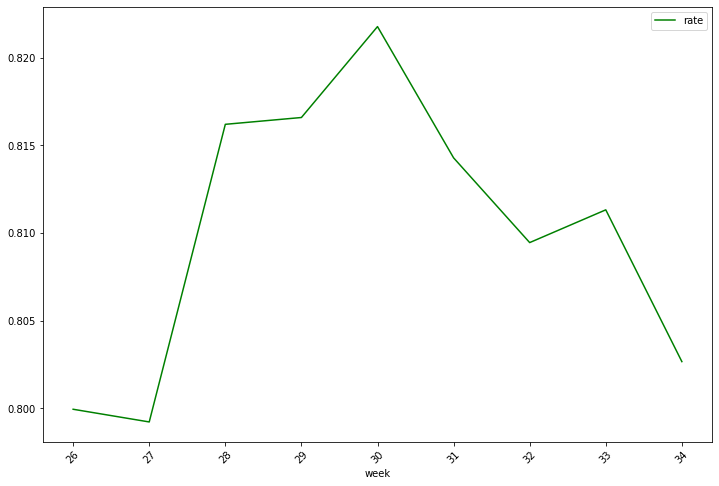

In [344]:
ax6 = exchange.groupby('week').mean().plot(kind='line',rot=45,figsize=(12,8),label = 'Exchange rate',color='green')

## TO DO 

#### check valid period
#### add vertical line
#### check textblob


## Valid period

In [ ]:
## check valid period

